In [1]:
import pandas as pd
import statistics
import researchpy as rp
import seaborn as sns
import matplotlib.pyplot as plt

Гипотеза: отмена товара характерна для случаев, когда заказ начинают собирать на следующий день или позже.

In [2]:
troubles = pd.read_csv('troubles.csv')

In [3]:
troubles.head()

,order_id,item_id,state,city,retailer_id,store_id,starts_at,ends_at,created_at,shipped_at
0,557,5384692,canceled,1.0,1.0,14,2018-01-09 06:00:00,2018-01-09 08:00:00,2018-01-08 15:47:37,2018-01-09 08:42:14
1,557,5384705,canceled,1.0,1.0,14,2018-01-09 06:00:00,2018-01-09 08:00:00,2018-01-08 15:47:37,2018-01-09 08:42:14
2,557,5384740,replaced,1.0,1.0,14,2018-01-09 06:00:00,2018-01-09 08:00:00,2018-01-08 15:47:37,2018-01-09 08:42:14
3,557,5390675,canceled,1.0,1.0,14,2018-01-09 06:00:00,2018-01-09 08:00:00,2018-01-08 15:47:37,2018-01-09 08:42:14
4,557,5390725,canceled,1.0,1.0,14,2018-01-09 06:00:00,2018-01-09 08:00:00,2018-01-08 15:47:37,2018-01-09 08:42:14


In [4]:
troubles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838063 entries, 0 to 838062
Data columns (total 10 columns):
order_id       838063 non-null int64
item_id        838063 non-null int64
state          838063 non-null object
city           831713 non-null float64
retailer_id    831713 non-null float64
store_id       838063 non-null int64
starts_at      838053 non-null object
ends_at        838053 non-null object
created_at     838063 non-null object
shipped_at     838063 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 63.9+ MB


In [5]:
troubles.dropna(subset=['starts_at'], inplace=True)

In [6]:
troubles.drop(['item_id', 'state'], axis=1, inplace=True)

In [7]:
troubles.drop_duplicates(inplace=True)

In [8]:
troubles['created_at'] = pd.to_datetime(troubles.created_at)
troubles['starts_at'] = pd.to_datetime(troubles.starts_at)

In [9]:
troubles['hours_to_start'] = (troubles['starts_at'] - troubles['created_at']).astype('timedelta64[h]').astype(int)

In [10]:
troubles['created_at'] = troubles.created_at.dt.day
troubles['starts_at'] = troubles.starts_at.dt.day

In [11]:
def check_day(row):
    if row['starts_at'] != row['created_at'] or row['hours_to_start'] > 24:
        return 'Yes'
    else:
        return 'No'

In [12]:
troubles['start_next_day'] = troubles.apply(check_day, axis=1)

In [13]:
print(troubles.order_id.count(), '- количество заказов в которых были отмены|замены')

239684 - количество заказов в которых были отмены|замены


In [14]:
troubles.groupby('start_next_day').count()['order_id'].reset_index().rename(
    columns={'order_id':'count_troubles'})

,start_next_day,count_troubles
0,No,68515
1,Yes,171169


Действительно, можно избежать большей части отмен, если все заказы будут собираться в день их создания.
Необходимо выяснить причину задержки, ведь заявлено что доставка происходит день в день.

In [15]:
troubles.describe()

,order_id,city,retailer_id,store_id,starts_at,created_at,hours_to_start
count,2.396840e+05,238308.000000,238308.000000,239684.000000,239684.000000,239684.000000,239684.000000
mean,4.163107e+06,1.894922,1.418387,23.738723,15.832121,15.889117,107.626483
std,6.450788e+05,3.100088,2.330464,30.009810,8.874638,8.839945,421.694139
min,5.570000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,-56.000000
25%,3.629096e+06,1.000000,1.000000,8.000000,8.000000,8.000000,8.000000
50%,4.102606e+06,1.000000,1.000000,11.000000,16.000000,16.000000,20.000000
75%,4.683724e+06,1.000000,1.000000,21.000000,23.000000,23.000000,47.000000
max,5.513202e+06,23.000000,16.000000,120.000000,31.000000,31.000000,12361.000000


In [16]:
troubles[troubles['hours_to_start']<0]

,order_id,city,retailer_id,store_id,starts_at,ends_at,created_at,shipped_at,hours_to_start,start_next_day
23981,3210889,1.0,1.0,1,13,2018-01-13 06:00:00,13,2018-01-13 18:16:07,-15,No
453661,4082090,1.0,1.0,1,3,2019-01-03 08:00:00,3,2019-01-04 04:30:26,-8,No
478843,4139408,1.0,1.0,8,31,2018-12-31 18:00:00,31,2018-12-31 19:45:00,-1,No
542817,4290200,1.0,1.0,10,22,2019-02-22 13:00:00,24,2019-02-25 17:13:00,-56,Yes
634452,4543736,1.0,1.0,18,30,2019-04-30 07:00:00,30,2019-04-30 14:26:25,-9,No
643679,4571052,1.0,1.0,1,25,2019-04-25 08:00:00,25,2019-04-25 13:30:29,-5,No


В данных найдены ошибки. В 6 случаях время начала доставки раньше чем создания самого заказа.

In [17]:
orders = pd.read_csv('orders_sber.csv')

In [18]:
orders.head()

,order_id,user_id,item_total,promo_total,cost,total_cost,total_quantity,total_weight,created_at,shipped_at,delivery_starts_at,delivery_ends_at,store_id,store_city,retailer_id,ship_address_id,lat,lon,state
0,557,97,5205,-200.0,0.0,0.0,13,6085,2018-01-08 15:47:37,2018-01-09 08:42:14,2018-01-09 06:00:00,2018-01-09 08:00:00,14,1.0,1.0,431346,55.671838,37.459107,shipped
1,4123,333,4886,0.0,299.0,0.0,42,15765,2018-12-29 13:26:01,2019-01-01 11:23:18,2019-01-01 10:00:00,2019-01-01 12:00:00,1,1.0,1.0,1222006,55.838648,37.644950,shipped
2,4537,364,3014,0.0,299.0,299.0,2,18000,2018-03-22 06:48:39,2018-03-24 18:50:43,2018-03-24 17:00:00,2018-03-24 19:00:00,8,1.0,1.0,577850,55.751306,37.811747,shipped
3,135575,604,4533,0.0,299.0,0.0,14,14395,2018-12-29 12:24:40,2018-12-29 19:04:00,2018-12-29 18:00:00,2018-12-29 20:00:00,10,1.0,1.0,1058806,55.843686,37.438182,shipped
4,137642,834,3880,0.0,299.0,299.0,98,25680,2018-07-19 18:46:39,2018-07-20 05:55:56,2018-07-20 05:00:00,2018-07-20 07:00:00,21,1.0,1.0,718114,55.755488,37.598053,shipped


In [19]:
orders['month_order'] = pd.to_datetime(orders.created_at).dt.month

In [20]:
orders['hour_order'] = pd.to_datetime(orders.created_at).dt.hour

In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334245 entries, 0 to 334244
Data columns (total 21 columns):
order_id              334245 non-null int64
user_id               334245 non-null int64
item_total            334245 non-null int64
promo_total           334245 non-null float64
cost                  334245 non-null float64
total_cost            334245 non-null float64
total_quantity        334245 non-null int64
total_weight          334245 non-null int64
created_at            334245 non-null object
shipped_at            334245 non-null object
delivery_starts_at    334244 non-null object
delivery_ends_at      334244 non-null object
store_id              334245 non-null int64
store_city            332629 non-null float64
retailer_id           332629 non-null float64
ship_address_id       334245 non-null int64
lat                   334231 non-null float64
lon                   334231 non-null float64
state                 334245 non-null object
month_order           334245 non-n

Существуют пробелы в данных в графах: город в котором расположен магазин и ритейлер, а так же в адресе покупателя. Необходимо выяснить с чем связана эта проблема при получении данных.

In [22]:
orders.describe().round()

,order_id,user_id,item_total,promo_total,cost,total_cost,total_quantity,total_weight,store_id,store_city,retailer_id,ship_address_id,lat,lon,month_order,hour_order
count,334245.0,334245.0,334245.0,334245.0,334245.0,334245.0,334245.0,334245.0,334245.0,332629.0,332629.0,334245.0,334231.0,334231.0,334245.0,334245.0
mean,4188269.0,177843.0,4918.0,-67.0,258.0,189.0,44.0,26926.0,23.0,2.0,1.0,1388983.0,56.0,39.0,6.0,12.0
std,658829.0,130990.0,5526.0,305.0,172.0,175.0,75.0,41873.0,30.0,3.0,2.0,610806.0,1.0,5.0,3.0,5.0
min,557.0,31.0,0.0,-39899.0,0.0,-298.0,0.0,0.0,1.0,1.0,1.0,6017.0,0.0,0.0,1.0,0.0
25%,3634639.0,84872.0,2566.0,0.0,199.0,0.0,18.0,9685.0,8.0,1.0,1.0,853173.0,56.0,38.0,4.0,8.0
50%,4134595.0,146590.0,3873.0,0.0,299.0,199.0,31.0,18180.0,11.0,1.0,1.0,1333773.0,56.0,38.0,6.0,12.0
75%,4745424.0,243751.0,5806.0,0.0,299.0,299.0,50.0,31935.0,21.0,1.0,1.0,1890743.0,56.0,38.0,8.0,16.0
max,5513202.0,682383.0,480746.0,0.0,9500.0,9500.0,7728.0,3864000.0,120.0,23.0,16.0,2669705.0,56.0,73.0,12.0,23.0


Так же существуют ошибки данных связанные с тем, что в заказе может быть 0 в графе количество товаров и общий вес

In [23]:
users_count = orders.groupby('user_id').count().sort_values('order_id', ascending=False
              )['order_id'].reset_index().rename(columns={'order_id' : 'count_orders'})
users_count.head()

,user_id,count_orders
0,25097,475
1,42230,433
2,129033,352
3,91068,301
4,56017,280


In [24]:
q = users_count.user_id.count()
w = users_count[users_count.count_orders > 1].user_id.count()
print(q, '- количество nользователей\n', w, '- количество пользователей совершивших повторную покупку\n',
      round(w/(q/100), 3), '- их процент')

119031 - количество nользователей
 43442 - количество пользователей совершивших повторную покупку
 36.496 - их процент


In [25]:
print(round(users_count[users_count.count_orders > 1]['count_orders'].mean(), 2),
      '- среднее количество заказов на постоянного клиента')

5.95 - среднее количество заказов на постоянного клиента


Более 63% пользователей не воспользовались сервисом повторно, стоит поработать над удержанием клиентов.

In [26]:
orders.groupby('state').count()['lat'].reset_index().rename(columns={'lat':'count'})

,state,count
0,canceled,13
1,pending,7
2,shipped,334211


Количество отмен заказов достаточно маленькое. Недостаточное для проведения анализа причин.

In [27]:
orders.groupby('store_city')['item_total', 'total_cost'].mean().round().sort_values('total_cost', ascending=False)

,item_total,total_cost
store_city,,
1.0,5083.0,202.0
20.0,5042.0,159.0
23.0,4750.0,136.0
2.0,3983.0,125.0
10.0,3755.0,98.0
5.0,4016.0,90.0
8.0,3602.0,86.0
13.0,3582.0,86.0


In [28]:
retailer = orders.groupby('retailer_id')['item_total', 'total_cost'].mean().round().sort_values(
    'item_total', ascending=False)
retailer

,item_total,total_cost
retailer_id,,
1.0,4970.0,190.0
15.0,3402.0,168.0
8.0,3268.0,184.0
16.0,3124.0,161.0


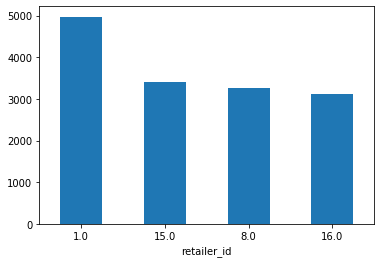

In [29]:
retailer.item_total.plot(kind='bar', rot=0)

Проверим гипотезу, что средний чек на покупки у ритейлера 1 статистически значимо отличается от остальных

In [30]:
one_retailer = orders[orders['retailer_id'] == 1].item_total.sample(10818)
other_retailer = orders[orders['retailer_id'] != 1].item_total

In [31]:
other_retailer.count()

10818

In [32]:
statistics.variance(one_retailer), statistics.variance(other_retailer)

(45786465.68128248, 4850266.320511459)

In [33]:
descriptives, results = rp.ttest(one_retailer, other_retailer, equal_variances=True)

In [34]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,item_total,10818.0,4987.830837,6766.569713,65.057156,4860.306886,5115.354789
1,item_total,10818.0,3346.132187,2202.332019,21.174312,3304.626654,3387.637720
2,combined,21636.0,4166.981512,5098.138926,34.659571,4099.046201,4234.916823


In [35]:
results

,Independent t-test,results
0,Difference (item_total - item_total) =,1641.6987
1,Degrees of freedom =,21634.0000
2,t =,23.9957
3,Two side test p value =,0.0000
4,Difference < 0 p value =,1.0000
5,Difference > 0 p value =,0.0000
6,Cohen's d =,0.3263
7,Hedge's g =,0.3263
8,Glass's delta =,0.2426
9,r =,0.1610


p-value < 0.05, поэтому можно сказать, что имеется статистическое различие между выборками. Наша гипотеза верна.

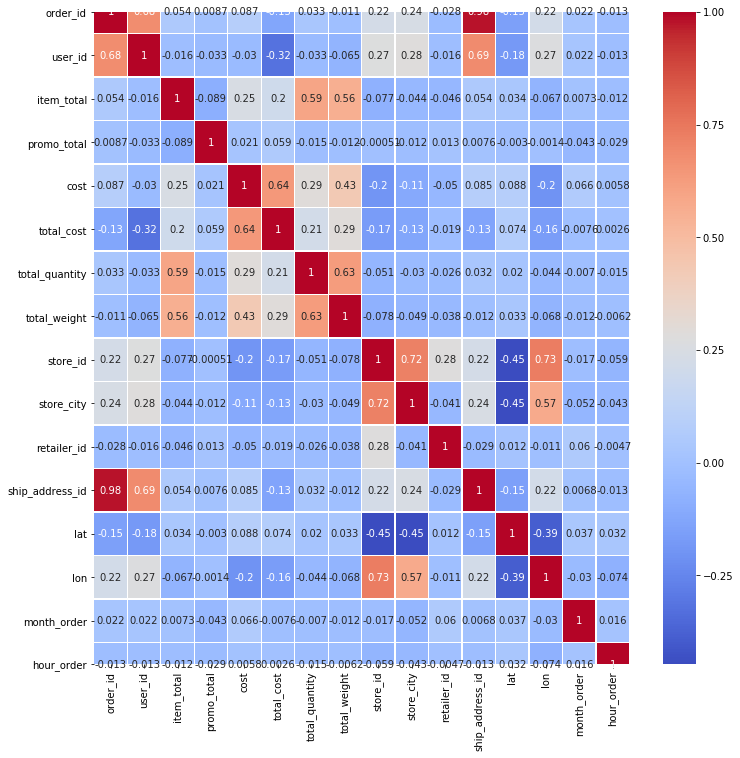

In [36]:
sns.heatmap(orders.corr(), annot=True, linewidths=0.3, cmap='coolwarm')
fig=plt.gcf()
fig.set_size_inches(12,12)

Неочевидных значимых корреляций признаков не обнаружено.

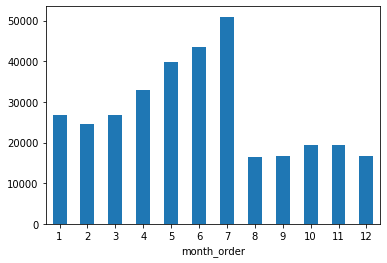

In [37]:
orders.groupby('month_order').count().order_id.rename(
                      columns={'order_id':'count_orders'}).plot(kind='bar', rot=0)

[]

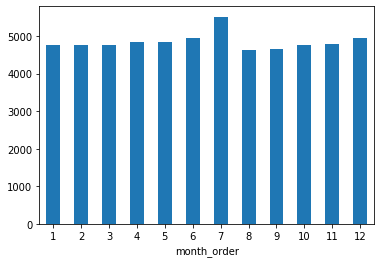

In [38]:
orders.groupby('month_order').mean().item_total.rename(columns={'order_id':'count_orders'}
                                                     ).plot(kind='bar', rot=0).plot(kind='bar', rot=0)

Можно отметить сезонный спад с августа и до нового года. Пик заказов в свою очередь приходится на период с конца весны и до августа. При этом значительных отличий среднего чека не наблюдается.

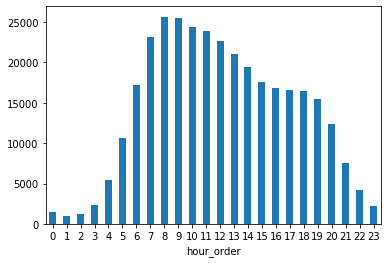

In [39]:
orders.groupby('hour_order').count().order_id.rename(
                      columns={'order_id':'count_orders'}).plot(kind='bar', rot=0)

Пик заказов по времени приходится на период с 7 утро и до обеда. Возможно в это время требуется больше доставщиков.